In [1]:
from google.colab import files
uploaded = files.upload()

Saving data.csv.xls to data.csv.xls


正在上传数据文件...


Saving data.csv.xls to data.csv (1).xls
原始数据行数: 4600
原始列: ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']

清洗后数据行数: 3757
              price  sqft_living     bedrooms    bathrooms
count  3.757000e+03  3757.000000  3757.000000  3757.000000
mean   4.731519e+05  1926.822199     3.316210     2.049241
min    7.800000e+03   370.000000     1.000000     0.750000
25%    3.100000e+05  1390.000000     3.000000     1.500000
50%    4.370000e+05  1850.000000     3.000000     2.000000
75%    5.973260e+05  2380.000000     4.000000     2.500000
max    1.150000e+06  4130.000000     9.000000     5.750000
std    2.074133e+05   706.241941     0.869606     0.690970

训练集: 2629 条, 测试集: 1128 条
交叉验证 R²: 0.542 (+/- 0.046)

=== 模型评估结果 ===
RMSE: $138,191.03
MAE : $106,776.96
MAPE: 26.04%
R²  : 0.579


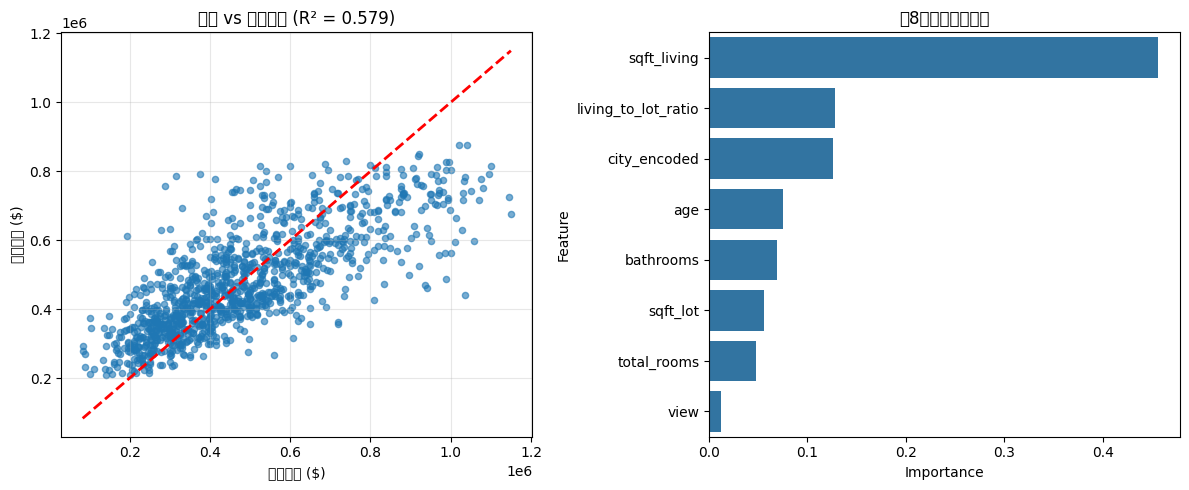


平均绝对误差: $106,776.96
中位数绝对误差: $86,186.04

按价格区间误差分析:
                      Absolute_Error            Actual
                                mean     median  count
price                                                 
(81933.0, 296400.0]        104397.13   91525.97    227
(296400.0, 509800.0]        78355.48   58088.16    480
(509800.0, 723200.0]       103070.78   94685.05    259
(723200.0, 936600.0]       157987.02  148532.73    112
(936600.0, 1150000.0]      294915.05  275718.31     50


In [2]:
# ==========================================
# 随机森林模型（使用 MTL 数据清洗逻辑）
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1: 数据加载
# -------------------------------
print("正在上传数据文件...")
uploaded = files.upload()
path = list(uploaded.keys())[0]
df = pd.read_csv(path, encoding_errors="ignore")

print(f"原始数据行数: {len(df)}")
print("原始列:", df.columns.tolist())

# -------------------------------
# Step 2: 严格数据清洗（与 MTL 一致）
# -------------------------------

# 删除关键字段缺失的记录
df = df.dropna(subset=['price', 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'date'])

# 日期转换
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# 派生字段
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['zip'] = df['statezip'].astype(str).str.split().str[-1]

# 删除不合理值
df = df[df['bedrooms'] > 0]
df = df[df['bathrooms'] > 0]
df = df[(df['sqft_living'] > 100) & (df['sqft_lot'] > 100)]
df = df[(df['floors'] > 0) & (df['floors'] <= 4)]
df = df[df['yr_built'] >= 1900]
df = df[df['price'] > 0]

# IQR 去除极端值
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

df = remove_outliers(df, 'price')
df = remove_outliers(df, 'sqft_living')
df = remove_outliers(df, 'sqft_lot')

print("\n清洗后数据行数:", len(df))
print(df.describe()[['price', 'sqft_living', 'bedrooms', 'bathrooms']])

# -------------------------------
# Step 3: 特征工程（与RF保持一致）
# -------------------------------

df['age'] = 2014 - df['yr_built']
df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df['living_to_lot_ratio'] = df['sqft_living'] / df['sqft_lot']

le_city = LabelEncoder()
df['city_encoded'] = le_city.fit_transform(df['city'])

core_features = [
    'sqft_living', 'bathrooms', 'bedrooms', 'sqft_lot',
    'floors', 'waterfront', 'view', 'condition',
    'age', 'is_renovated', 'total_rooms', 'living_to_lot_ratio', 'city_encoded'
]

X = df[core_features]
y = df['price']

# -------------------------------
# Step 4: 数据划分
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"\n训练集: {len(X_train)} 条, 测试集: {len(X_test)} 条")

# -------------------------------
# Step 5: 随机森林建模
# -------------------------------
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features=0.5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# 交叉验证
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"交叉验证 R²: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# -------------------------------
# Step 6: 模型评估
# -------------------------------
y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print("\n=== 模型评估结果 ===")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE : ${mae:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.3f}")

# -------------------------------
# Step 7: 可视化
# -------------------------------
plt.figure(figsize=(12, 5))

# 实际 vs 预测
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('实际价格 ($)')
plt.ylabel('预测价格 ($)')
plt.title(f'实际 vs 预测价格 (R² = {r2:.3f})')
plt.grid(alpha=0.3)

# 特征重要性
importance_df = pd.DataFrame({
    'Feature': core_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=importance_df.head(8))
plt.title('前8个最重要的特征')
plt.tight_layout()
plt.show()

# -------------------------------
# Step 8: 误差分析
# -------------------------------
abs_errors = np.abs(y_test - y_pred)
print(f"\n平均绝对误差: ${abs_errors.mean():,.2f}")
print(f"中位数绝对误差: ${np.median(abs_errors):,.2f}")

price_bins = pd.cut(y_test, bins=5)
error_by_price = pd.DataFrame({
    'Absolute_Error': abs_errors,
    'Actual': y_test
}).groupby(price_bins).agg({'Absolute_Error': ['mean', 'median'], 'Actual': 'count'}).round(2)

print("\n按价格区间误差分析:")
print(error_by_price)
